In [ ]:
# experiment_linreg.py
import numpy as np
import time
from functools import partial
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(0)

In [ ]:
def make_data(n=200, d=50, cond=10.0, sigma=0.1):
    # generate singular values spaced to create given condition number
    U, _ = np.linalg.qr(np.random.randn(n, n))
    V, _ = np.linalg.qr(np.random.randn(d, d))
    # singular values from 1 to 1/cond (for X shape nxd we use min(n,d))
    k = min(n, d)
    s = np.linspace(1.0, 1.0/cond, k)
    S = np.zeros((n, d))
    S[:k, :k] = np.diag(s)
    X = (U @ S @ V.T)[:n, :d]
    wstar = np.random.randn(d)
    y = X.dot(wstar) + sigma * np.random.randn(n)
    return X, y, wstar

In [ ]:
def mse_loss_and_grad(w, X, y):
    # return loss (scalar) and gradient (vector)
    n = X.shape[0]
    r = X.dot(w) - y
    loss = 0.5 * np.mean(r**2)   # 0.5* MSE
    grad = (X.T.dot(r)) / n
    return loss, grad

def gradient_descent(X, y, w0=None, lr=1.0, max_iter=5000, tol=1e-8, record_every=10):
    n, d = X.shape
    if w0 is None:
        w = np.zeros(d)
    else:
        w = w0.copy()
    history = {'loss': [], 'time': [], 'grad_norm': []}
    t0 = time.perf_counter()
    for it in range(1, max_iter+1):
        loss, grad = mse_loss_and_grad(w, X, y)
        gnorm = np.linalg.norm(grad)
        w -= lr * grad
        if it % record_every == 0 or it == 1:
            history['loss'].append(loss)
            history['time'].append(time.perf_counter() - t0)
            history['grad_norm'].append(gnorm)
        if gnorm < tol:
            break
    return w, history

# Data
# X, y, wstar = make_data(n=500, d=50, cond=100.0, sigma=0.1)
X, y, wstar = make_data(n=1000, d=200, cond=1000.0, sigma=0.5)

n, d = X.shape

# initial guess
w0 = np.zeros(d)

In [ ]:
# --- Gradient Descent (choose lr carefully) ---
# A heuristic: lr ~ 1 / L where L = max eigenvalue of (X^T X)/n
eigvals = np.linalg.eigvalsh((X.T @ X) / n)
L = eigvals.max()
print("L (Lipschitz):", L)
lr = 1.0 / L * 0.9  # safe step
w_gd, hist_gd = gradient_descent(X, y, w0=w0, lr=lr, max_iter=2000, record_every=5)

# --- BFGS via SciPy (requires objective and grad) ---
def obj(w, X, y):
    loss, _ = mse_loss_and_grad(w, X, y)
    return loss

def grad_fn(w, X, y):
    _, g = mse_loss_and_grad(w, X, y)
    return g

t0 = time.perf_counter()
res = minimize(fun=partial(obj, X=X, y=y),
               x0=w0,
               jac=partial(grad_fn, X=X, y=y),
               method='BFGS',
               options={'gtol':1e-8, 'maxiter':500})
t_bfgs = time.perf_counter() - t0
w_bfgs = res.x
print("BFGS success:", res.success, "nit:", res.nit, "time:", t_bfgs, "final loss:", res.fun)

L (Lipschitz): 0.0009999999999999994
BFGS success: False nit: 500 time: 1.004977949996828 final loss: 0.10076802716112702


In [ ]:
# --- Compare final results ---
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

print("GD final loss:", hist_gd['loss'][-1], "param_err:", np.linalg.norm(w_gd - wstar))
print("BFGS final loss:", obj(w_bfgs, X, y), "param_err:", np.linalg.norm(w_bfgs - wstar))

GD final loss: 0.1006871335187896 param_err: 33.103624154673504
BFGS final loss: 0.10076802716112702 param_err: 30.464251871034364


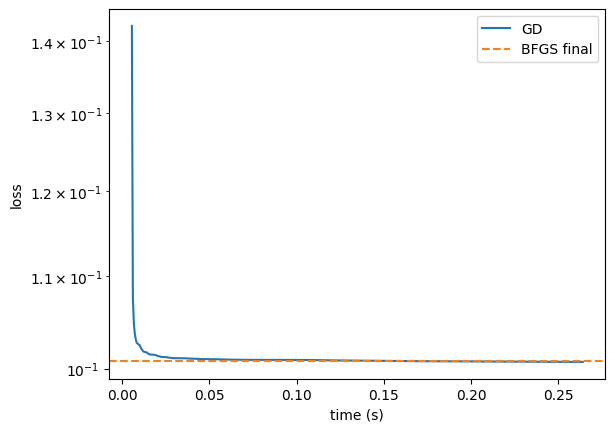

In [ ]:
# --- Plot loss curves (loss vs time) ---
plt.figure()
plt.plot(hist_gd['time'], hist_gd['loss'], label='GD')
plt.axhline(obj(w_bfgs, X, y), color='C1', linestyle='--', label='BFGS final')
plt.xlabel('time (s)')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

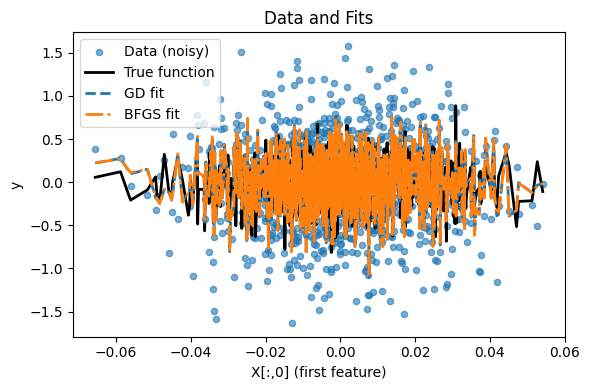

In [ ]:
# --- Plot 2: data + true curve + fitted curves ---
plt.figure(figsize=(6, 4))

# 取第一个特征作为横坐标
x_axis = X[:, 0]

# 排序后绘制平滑曲线
sort_idx = np.argsort(x_axis)
x_sorted = x_axis[sort_idx]

y_true = X @ wstar
y_gd = X @ w_gd
y_bfgs = X @ w_bfgs

plt.scatter(x_axis, y, s=20, alpha=0.6, label="Data (noisy)")
plt.plot(x_sorted, y_true[sort_idx], "k-", lw=2, label="True function")
plt.plot(x_sorted, y_gd[sort_idx], "C0--", lw=2, label="GD fit")
plt.plot(x_sorted, y_bfgs[sort_idx], "C1-.", lw=2, label="BFGS fit")

plt.xlabel("X[:,0] (first feature)")
plt.ylabel("y")
plt.legend()
plt.title("Data and Fits")
plt.tight_layout()
plt.show()

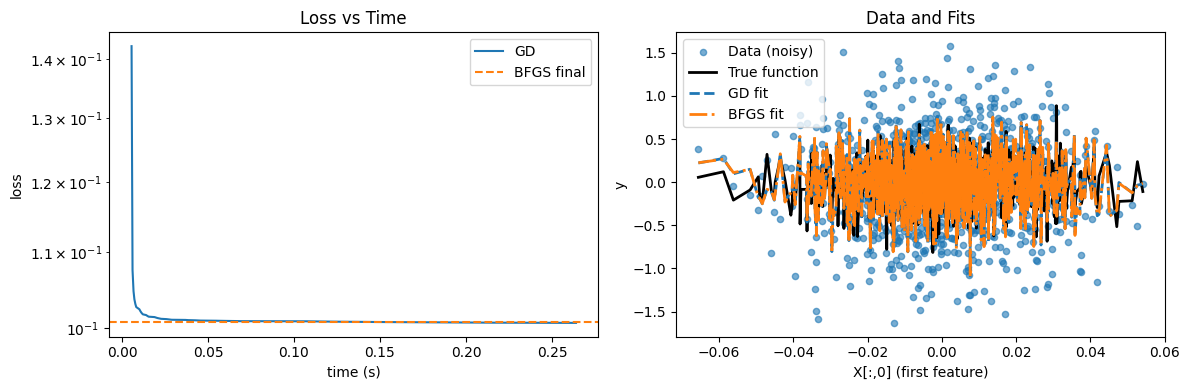

In [ ]:
# --- Plot: side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (1) Loss vs Time
axes[0].plot(hist_gd["time"], hist_gd["loss"], label="GD")
axes[0].axhline(obj(w_bfgs, X, y), color="C1", linestyle="--", label="BFGS final")
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("loss")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].set_title("Loss vs Time")

# (2) Data and Fits
x_axis = X[:, 0]
sort_idx = np.argsort(x_axis)
x_sorted = x_axis[sort_idx]

y_true = X @ wstar
y_gd = X @ w_gd
y_bfgs = X @ w_bfgs

axes[1].scatter(x_axis, y, s=20, alpha=0.6, label="Data (noisy)")
axes[1].plot(x_sorted, y_true[sort_idx], "k-", lw=2, label="True function")
axes[1].plot(x_sorted, y_gd[sort_idx], "C0--", lw=2, label="GD fit")
axes[1].plot(x_sorted, y_bfgs[sort_idx], "C1-.", lw=2, label="BFGS fit")
axes[1].set_xlabel("X[:,0] (first feature)")
axes[1].set_ylabel("y")
axes[1].legend()
axes[1].set_title("Data and Fits")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# --- Compute metrics ---
mse_gd = mse(y, y_gd)
mse_bfgs = mse(y, y_bfgs)

results = pd.DataFrame({
    "Method": ["Gradient Descent", "BFGS"],
    "Final Loss": [hist_gd['loss'][-1], obj(w_bfgs, X, y)],
    "MSE": [mse_gd, mse_bfgs],
    "Param Error (||w - w*||)": [
        np.linalg.norm(w_gd - wstar),
        np.linalg.norm(w_bfgs - wstar)
    ]
})

print("\n=== Results Comparison ===")
print(results.to_string(index=False))


=== Results Comparison ===
          Method  Final Loss      MSE  Param Error (||w - w*||)
Gradient Descent    0.100687 0.201374                 33.103624
            BFGS    0.100768 0.201536                 30.464252


In [ ]:
import time
from functools import partial
from scipy.optimize import minimize

# 容器用于存历史
bfgs_hist = {"loss": [], "time": [], "w": []}


def obj_only(w, X, y):
    r = X.dot(w) - y
    return 0.5 * np.mean(r**2)


def grad_only(w, X, y):
    r = X.dot(w) - y
    return (X.T.dot(r)) / X.shape[0]


# callback 接收当前参数向量（scipy 对于 BFGS 支持 callback(xk)）
def make_callback(X, y, hist, t0):
    def callback(xk):
        hist["w"].append(xk.copy())
        hist["loss"].append(obj_only(xk, X, y))
        hist["time"].append(time.perf_counter() - t0)

    return callback


w0 = np.zeros(d)
t0 = time.perf_counter()
res = minimize(
    fun=partial(obj_only, X=X, y=y),
    x0=w0,
    jac=partial(grad_only, X=X, y=y),
    method="BFGS",
    callback=make_callback(X, y, bfgs_hist, t0),
    options={"gtol": 1e-8, "maxiter": 500, "disp": False},
)
bfgs_time_total = time.perf_counter() - t0

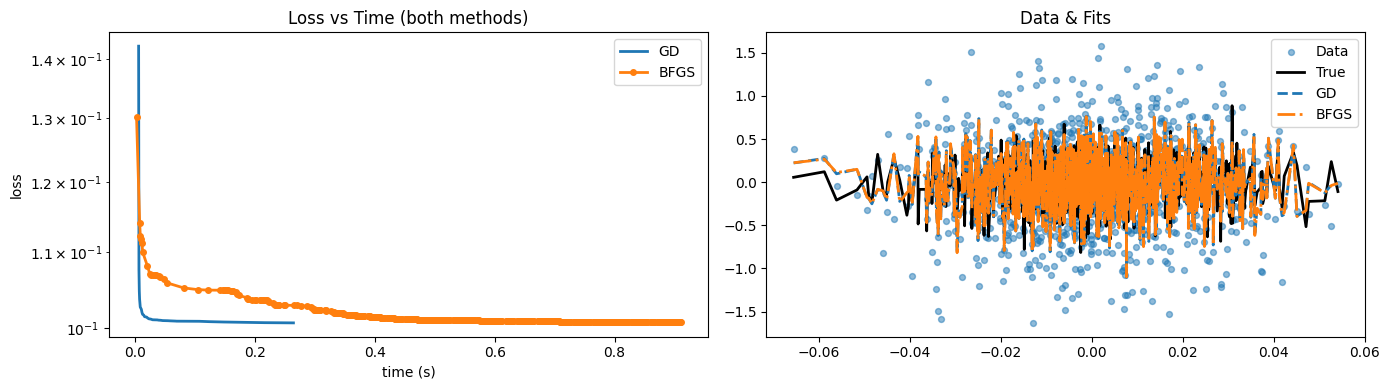


=== Results Comparison ===
          Method  Final Loss      MSE  Param Err  Total Time (s)  Iters
Gradient Descent    0.100687 0.201374  33.103624        0.264000    401
            BFGS    0.100768 0.201536  30.464252        0.911548    500

=== Time-to-eps (s) ===
     eps  GD_time  BFGS_time
0.010000 0.006125   0.012261
0.000100 0.155670   0.850771
0.000001 0.260946        inf


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from functools import partial
from scipy.optimize import minimize

# 假设已有 X, y, wstar, gradient_descent, mse, obj_only, grad_only
# 并且 hist_gd, w_gd 已经得出（如果还没，可先跑 GD）

# 1) 记录 BFGS 历史 (如前面)
bfgs_hist = {"loss": [], "time": [], "w": []}
t0 = time.perf_counter()
res = minimize(
    fun=partial(obj_only, X=X, y=y),
    x0=np.zeros(d),
    jac=partial(grad_only, X=X, y=y),
    method="BFGS",
    callback=make_callback(X, y, bfgs_hist, t0),
    options={"gtol": 1e-12, "maxiter": 500, "disp": False},
)
bfgs_total_time = time.perf_counter() - t0
w_bfgs = res.x

# 2) compute predictions
y_gd = X @ w_gd
y_bfgs = X @ w_bfgs

# 3) compute MSE etc
mse_gd = mse(y, y_gd)
mse_bfgs = mse(y, y_bfgs)
param_err_gd = np.linalg.norm(w_gd - wstar)
param_err_bfgs = np.linalg.norm(w_bfgs - wstar)

# 4) time-to-eps (示例 eps)
eps_list = [1e-2, 1e-4, 1e-6]
target_base = min(bfgs_hist["loss"][-1], hist_gd["loss"][-1])


def t_to_eps(hist_loss, hist_time, eps):
    target = target_base + eps
    for L, t in zip(hist_loss, hist_time):
        if L <= target:
            return t
    return np.inf


rows = []
for eps in eps_list:
    rows.append(
        {
            "eps": eps,
            "GD_time": t_to_eps(hist_gd["loss"], hist_gd["time"], eps),
            "BFGS_time": t_to_eps(bfgs_hist["loss"], bfgs_hist["time"], eps),
        }
    )
time_df = pd.DataFrame(rows)

# 5) Plot side-by-side (loss vs time includes both histories)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# loss vs time
axes[0].plot(hist_gd["time"], hist_gd["loss"], label="GD", lw=2)
axes[0].plot(
    bfgs_hist["time"], bfgs_hist["loss"], label="BFGS", lw=2, marker="o", markersize=4
)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("loss")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].set_title("Loss vs Time (both methods)")

# data & fits (use first feature or PCA projection)
x_axis = X[:, 0]
sort_idx = np.argsort(x_axis)
axes[1].scatter(x_axis, y, s=18, alpha=0.5, label="Data")
axes[1].plot(x_axis[sort_idx], (X @ wstar)[sort_idx], "k-", lw=2, label="True")
axes[1].plot(x_axis[sort_idx], y_gd[sort_idx], "C0--", lw=2, label="GD")
axes[1].plot(x_axis[sort_idx], y_bfgs[sort_idx], "C1-.", lw=2, label="BFGS")
axes[1].legend()
axes[1].set_title("Data & Fits")

plt.tight_layout()
plt.show()

# 6) Pretty results table
results = pd.DataFrame(
    {
        "Method": ["Gradient Descent", "BFGS"],
        "Final Loss": [hist_gd["loss"][-1], bfgs_hist["loss"][-1]],
        "MSE": [mse_gd, mse_bfgs],
        "Param Err": [param_err_gd, param_err_bfgs],
        "Total Time (s)": [hist_gd["time"][-1], bfgs_total_time],
        "Iters": [len(hist_gd["loss"]), res.nit],
    }
)
print("\n=== Results Comparison ===")
print(results.to_string(index=False))
print("\n=== Time-to-eps (s) ===")
print(time_df.to_string(index=False))